In [36]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset


In [37]:
dataset = read_csv('./data/VN30_price.csv', header=0, index_col=0)
dataset

,BID,BVH,CTG,FPT,GAS,HPG,KDH,MBB,MSN,MWG,...,PNJ,REE,SBT,SSI,STB,TCH,VCB,VIC,VNM,VN30
2016-12-30,10531.3,58200.0,15050.0,15852.0,60600.0,6770.2,9221.5,5151.6,43200.0,18328.0,...,22097.6,24650.0,20035.1,9521.4,9450.0,12181.1,26307.0,34711.0,99213.0,628.21
2017-01-03,11235.8,59300.0,16100.0,16158.2,60100.0,6903.6,9198.4,5059.6,43600.0,18411.0,...,22164.0,25000.0,21261.8,9740.0,8790.0,12181.1,27643.0,34380.0,100082.0,633.89
2017-01-04,11458.3,60100.0,16400.0,16302.3,61500.0,6903.6,9198.4,5004.4,42333.0,18481.0,...,22230.5,25000.0,20771.1,9740.0,8200.0,12109.0,27457.0,34752.0,100240.0,632.70
2017-01-05,11421.2,61100.0,16500.0,16248.3,61500.0,6919.3,8944.8,4967.6,42067.0,18540.0,...,22263.7,25300.0,20607.6,9764.3,8580.0,12289.2,27569.0,34959.0,100082.0,634.83
2017-01-06,11680.8,61400.0,16650.0,16194.3,60400.0,6809.4,9083.2,5059.6,42133.0,18540.0,...,22895.1,25000.0,20525.8,9861.4,8780.0,12217.1,28125.0,35620.0,99529.0,636.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,38800.0,45500.0,26050.0,76400.0,102600.0,17100.0,24650.0,16800.0,91500.0,42600.0,...,81000.0,70300.0,13750.0,17050.0,21900.0,6480.0,78900.0,52900.0,76000.0,987.77
2022-12-27,40000.0,46500.0,26600.0,76500.0,103100.0,18250.0,26350.0,17250.0,91600.0,43800.0,...,81000.0,72000.0,13850.0,18200.0,22500.0,6900.0,79100.0,53400.0,76600.0,1007.36
2022-12-28,41900.0,46700.0,27150.0,76700.0,103000.0,18200.0,27050.0,17450.0,93000.0,43000.0,...,82500.0,71800.0,14300.0,18150.0,22900.0,6900.0,80000.0,53500.0,77000.0,1013.95
2022-12-29,40000.0,46500.0,27000.0,76200.0,102600.0,18000.0,27950.0,17400.0,94000.0,42900.0,...,86000.0,71800.0,14500.0,17600.0,22350.0,6860.0,80700.0,53600.0,77000.0,1008.30


In [38]:
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,30] = encoder.fit_transform(values[:,30])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days_lag = 5
n_features = len(dataset.columns)

reframed = series_to_supervised(scaled, n_days_lag, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),...,var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t)
5,0.000000,0.342593,0.068278,0.000898,0.091456,0.013137,0.006481,0.007764,0.031313,0.000000,...,0.015211,0.009358,0.435183,0.085111,0.059194,0.211021,0.040850,0.027849,0.328323,0.028741
6,0.018314,0.357143,0.105773,0.004713,0.085439,0.016683,0.005940,0.003882,0.035224,0.001355,...,0.014764,0.000000,0.431790,0.083431,0.059545,0.201937,0.037662,0.025247,0.329021,0.029739
7,0.024098,0.367725,0.116486,0.006508,0.102286,0.016683,0.005940,0.001553,0.022837,0.002498,...,0.012973,0.006685,0.431790,0.082872,0.060595,0.205343,0.038191,0.026111,0.335301,0.033930
8,0.023133,0.380952,0.120057,0.005835,0.102286,0.017100,0.000000,0.000000,0.020237,0.003461,...,0.012973,0.010695,0.418221,0.084551,0.060946,0.201937,0.032357,0.026111,0.335301,0.032744
9,0.029881,0.384921,0.125414,0.005163,0.089049,0.014179,0.003242,0.003882,0.020882,0.003461,...,0.011631,0.012032,0.435183,0.085111,0.057793,0.199665,0.027582,0.028723,0.334603,0.030477


In [39]:
# split into train and test sets
n_obs = n_days_lag * n_features

values = reframed.values
n_train_days = int(len(reframed.index) * 0.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1196, 5, 22) (1196,) (299, 5, 22) (299,)


2023-05-14 12:54:59.646541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 12:54:59.651507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 12:54:59.653969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-05-14 12:55:00.010628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 12:55:00.013890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 12:55:00.015878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/30 - 6s - loss: 0.0077 - val_loss: 0.1464 - 6s/epoch - 214ms/step
Epoch 2/100
30/30 - 0s - loss: 0.0120 - val_loss: 0.1650 - 307ms/epoch - 10ms/step
Epoch 3/100
30/30 - 0s - loss: 0.0069 - val_loss: 0.0818 - 306ms/epoch - 10ms/step
Epoch 4/100
30/30 - 0s - loss: 0.0037 - val_loss: 0.0118 - 448ms/epoch - 15ms/step
Epoch 5/100
30/30 - 0s - loss: 0.0025 - val_loss: 0.0072 - 306ms/epoch - 10ms/step
Epoch 6/100
30/30 - 0s - loss: 0.0040 - val_loss: 0.0777 - 240ms/epoch - 8ms/step
Epoch 7/100
30/30 - 0s - loss: 0.0031 - val_loss: 0.1840 - 238ms/epoch - 8ms/step
Epoch 8/100
30/30 - 0s - loss: 0.0079 - val_loss: 0.1460 - 242ms/epoch - 8ms/step
Epoch 9/100
30/30 - 0s - loss: 0.0072 - val_loss: 0.0569 - 242ms/epoch - 8ms/step
Epoch 10/100
30/30 - 0s - loss: 0.0024 - val_loss: 0.0069 - 313ms/epoch - 10ms/step
Epoch 11/100
30/30 - 0s - loss: 0.0030 - val_loss: 0.0319 - 246ms/epoch - 8ms/step
Epoch 12/100
30/30 - 0s - loss: 0.0031 - val_loss: 0.1613 - 240ms/epoch - 8ms/step
Epoch 13/100
30/30 - 

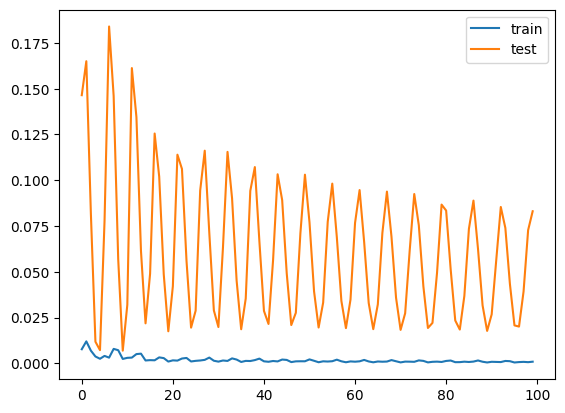

In [40]:
# design network
model = Sequential()

model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.2, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [41]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
def adjust(val, length= 6): return str(val).ljust(length)


In [42]:
# make a prediction
yhat = model.predict(test_X)
test_X_base = test_X.reshape((test_X.shape[0], n_days_lag*n_features))
# invert scaling for forecast
inv_yhat = concatenate((test_X_base[:, :n_features-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X_base[:, :n_features-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
print('\nForecast Accuracy of: VN30')
accuracy_prod = forecast_accuracy(inv_yhat, inv_y)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v, 4))

2023-05-14 12:55:33.161340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 12:55:33.164166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 12:55:33.165975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 4ms/step

Forecast Accuracy of: VN30
mape   :  0.1605
me     :  -223.5595
mae    :  227.9134
mpe    :  -0.1559
rmse   :  266.7029
corr   :  0.9708
minmax :  0.1604


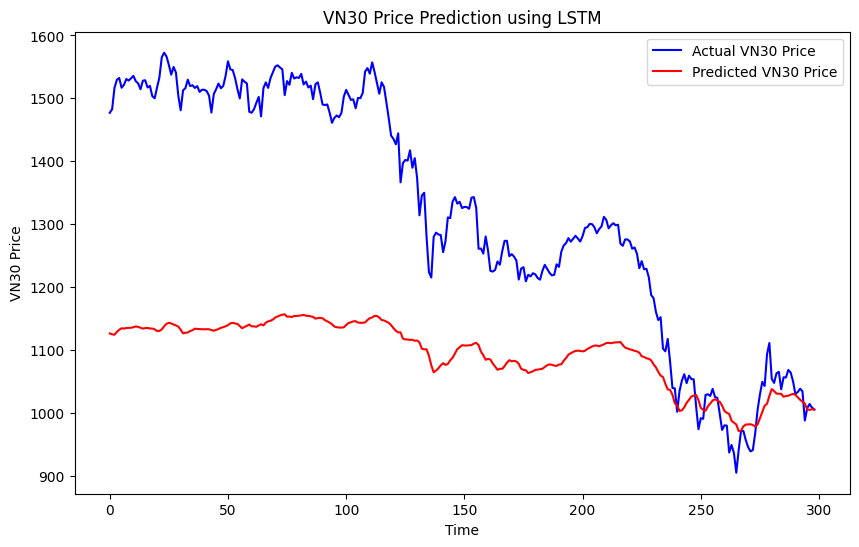

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, len(inv_yhat)), inv_y.flatten(), color='blue', label='Actual VN30 Price')
plt.plot(np.arange(0, len(inv_y)), inv_yhat.flatten(), color='red', label='Predicted VN30 Price')
plt.title('VN30 Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('VN30 Price')
plt.legend()
plt.show()

In [44]:
DataFrame({'pred': inv_yhat, 'true': inv_y})

,pred,true
0,1126.208374,1476.969971
1,1124.821045,1482.619995
2,1124.176147,1516.459961
3,1128.619385,1529.260010
4,1132.062256,1532.349976
...,...,...
294,1014.657227,987.770020
295,1005.463501,1007.359924
296,1004.592346,1013.950012
297,1005.699707,1008.300049
